In [ ]:
import keras as keras
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report

#import tensorflow_addons as tfa

Cargamos los datos tanto de entrada (train y test) y sus respectivos labels.

In [ ]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
def EDA_plothist(data,histname):
  unique, counts = np.unique(data, return_counts=True)
  counts = np.bincount(data)
  fig, ax = plt.subplots(figsize=(10,5))
  ax.bar(range(10), counts, width=0.8, align='center')
  ax.set(xticks=range(10), xlim=[-1, 10], title=histname)
  plt.show()

In [ ]:


#plt.imshow(x_train[1,...], cmap='gray')
#print(y_train.shape,x_train.shape)

# Exploratory Data Analisys
Observaremos sobre los datos a procesar, para caracterizar el problema a resolver.


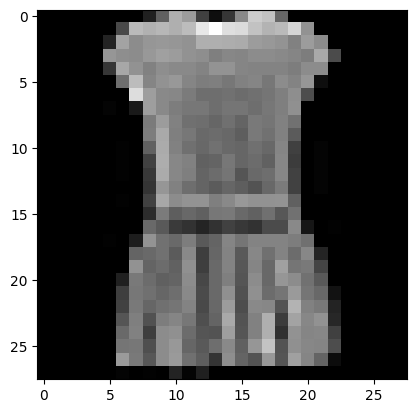

In [ ]:
plt.imshow(x_train[3,...], cmap="gray")

El dataset cuenta con 70.000 imagenes de 28x28px que corresponden a imagenes en un solo canal de 10 categorias de prendas de ropa diferentes. A continuacion mostramos un ejemplo de cada clase:

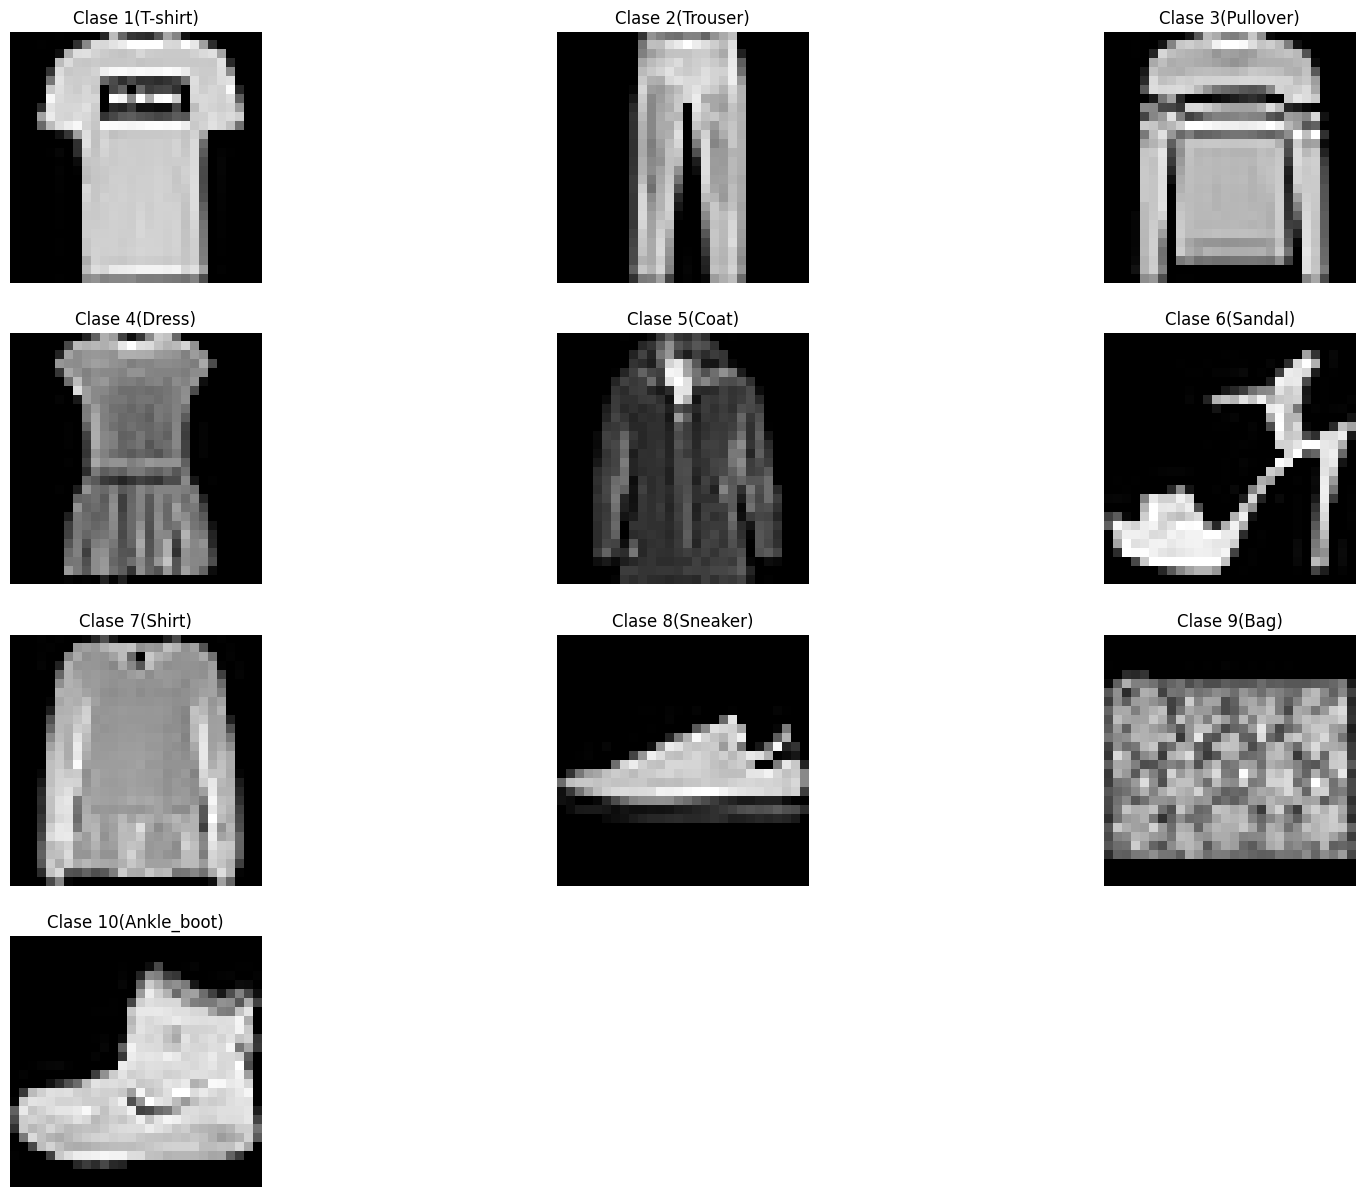

In [ ]:
#Indices a ejemplos

ejs=[1, 16, 5, 3, 19, 9, 18, 6, 23, 0]
prendas=[]
classes_fashion={
1: "T-shirt",
2: "Trouser",
3: "Pullover",
4: "Dress",
5: "Coat",
6: "Sandal",
7: "Shirt",
8: "Sneaker",
9: "Bag",
10: "Ankle_boot"}
# create figure
fig = plt.figure(figsize=(20, 15))
# setting values to rows and column variables
rows = 4
columns = 3
fig_counter=1
# Adds a subplot at the 1st position
for ej in ejs:
  fig.add_subplot(rows, columns, fig_counter)
  plt.imshow(x_train[ej],cmap="gray")
  plt.axis('off')
  plt.title("Clase "+str(fig_counter)+'('+classes_fashion[fig_counter]+')')
  fig_counter=fig_counter+1



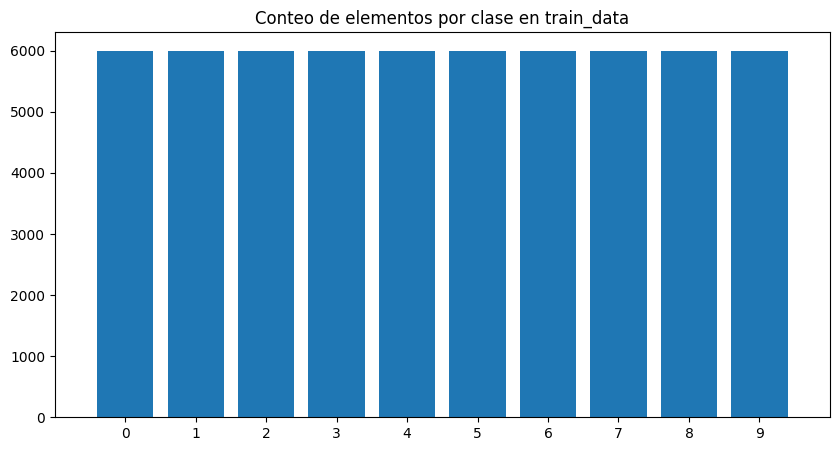

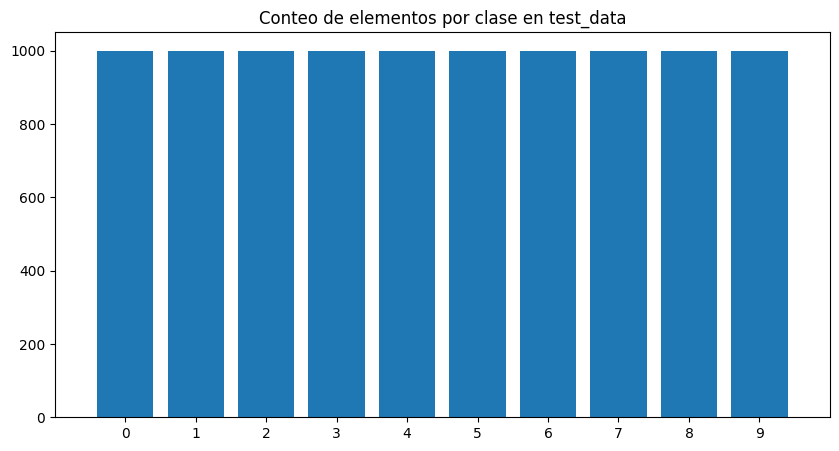

In [ ]:
# counts, bins = np.histogram(y_train)
# print(counts,"+  ",bins)
# plt.xticks(range(11));
# plt.hist(bins, bins=10, weights=counts, histtype='bar', align='mid')
EDA_plothist(y_train,"Conteo de elementos por clase en train_data")
EDA_plothist(y_test,"Conteo de elementos por clase en test_data")


#Procesamiento de datos:
1)One hot encoding de las clases:

In [ ]:

y_sparse_train = np.zeros([60000,10])
y_sparse_test = np.zeros([10000,10])
for idx in range(60000):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(10000):
    y_sparse_test[idx,y_test[idx]] = 1


2)Separo en train y validate, luego normalizo los datos:

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_sparse_train, test_size=0.3, random_state=125)
#x_train = tf.keras.utils.normalize(x_train)
#x_test = tf.keras.utils.normalize(x_test)
# Normalizacion "a mano"
x_train = x_train/255
x_test = x_test/255
#

Hasta aqui preprocesamiento
Ahora definiré el modelo propiamente.

In [ ]:
from keras.models import Sequential
import keras.layers
from keras.layers import Dense, Flatten
from keras.optimizers import SGD, Adam, adagrad




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Defino mis funciones de exploración
Pretendo loopear a traves de las mismas, creando a partir de ellas diversos modelos afín de compararlos.

In [ ]:
#Funcion que crea un modelo basado en un clasificador softmax de una capa de aplanamiento y una de clasificacion con activacion softmax
#Guardado de metricas y early stopping activados, modificable para realizar pruebas
# Parametros: Optimizador (string preseteado o callback), metodo de regularizacion de pesos y de inicializacion de pesos. Además se especidifca si se requiere o no de batch normalization
def new_model_softmax (optimizador,kernreg,kerninit,batch_normalization=False):
  nClases = 10
  model_name = "Modelo con optimizacion "+optimizador+", Regularizacion kernel "+kernreg+" y kerninit "+kerninit
  print(model_name)
  #Early Stopping
  es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
  #  min_delta=0.1,
    min_delta=30,
    patience=0,
    verbose=1,
    mode="max",
    baseline=60,
    restore_best_weights=True,
    start_from_epoch=0)
  #Callbacks para guardar datos
  mc = tf.keras.callbacks.ModelCheckpoint(model_name+'.h5', monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)
  model = Sequential()
  model.add(Flatten(input_shape=(28,28,1)))
  if bool(batch_normalization):
    model.add(layers.BatchNormalization())
  model.add(Dense(nClases, activation="softmax",kernel_regularizer=kernreg,kernel_initializer=kerninit))
  model.compile(loss= 'categorical_crossentropy', optimizer=optimizador,
                  metrics=["accuracy"])
  history = model.fit(x= x_train, y = y_train, validation_data=(x_validate, y_validate), batch_size = 32, epochs=200, callbacks=[es,mc])
  model.summary()
  val_los, val_acc = model.evaluate(x_test,y_sparse_test)
  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred, axis = 1)
  print(y_pred,y_test)
  classification_rep = classification_report(y_test,y_pred,output_dict=True)
  return (history,classification_rep,model_name)



#Funcion que plotea los graficos de accuracies y losses. Agrupa de a N modelos
def plot_compare(results_vector, models_perfig=4):
  model_count = len(results_vector)
  #Iteramos entre todos los modelos a.k.a resultados y agrupamos de a 4 por grafico.
  for i in range(model_count):
    plt.plot(results_vector[i][0].history['loss'], label="M "+str(i)+" train")#Plot de los
    plt.plot(results_vector[i][0].history['val_loss'],'--', label="M "+str(i)+" test")
    if (i+1)%models_perfig==0:
      plt.title('Losses vs Epoch')
      plt.legend(loc='upper right')
      plt.show()
    elif i+1==model_count:
      plt.title('Losses vs Epoch')
      plt.legend(loc='upper right')
      plt.show()


  for i in range(len(results_vector)):
    plt.plot(results_vector[i][0].history['accuracy'], label="M "+str(i)+" train")#Plot de los
    plt.plot(results_vector[i][0].history['val_accuracy'],'--' , label="M "+str(i)+" test")
    if (i+1)%4==0:
      plt.title('Accuracy vs Epoch')
      plt.legend(loc='lower right')
      plt.show()
    elif i+1==model_count:
      plt.title('Accuracy vs Epoch')
      plt.legend(loc='lower right')
      plt.show()

def plot_class_reports(results_vector):
  clases_dict=['0','1','2','3','4','5','6','7','8','9']
  metricas_dict=['precision','recall','f1-score','support']
  colores = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
  precision_vect= []
  recall_vect=[]
  f1_vect=[]
  nClases = 10
  axis_ID=0
  deca_count = 0
  x = np.arange(10)
  subplot_count = 3*((int(len(results_vector)/10))+1)
  fig, ax = plt.subplots(subplot_count,figsize=(25,15))
  print(len(results_vector))
  for j in range(len(results_vector)):
    if j>0 and (j%10)==0 :
      axis_ID = axis_ID + 3
      deca_count = deca_count + 10

    for i in range(nClases):
      precision_vect.append(results_vector[j][1][clases_dict[i]][metricas_dict[0]])
      recall_vect.append(results_vector[j][1][clases_dict[i]][metricas_dict[1]])
      f1_vect.append(results_vector[j][1][clases_dict[i]][metricas_dict[2]])
    ax[axis_ID].stem(x+(j-deca_count)*0.09, precision_vect[(j*10):(((j+1)*10))], label="M"+str(j),linefmt=colores[j-deca_count])
    ax[axis_ID].set(xlim=(0, 10), xticks=np.arange(0, 10),
      ylim=(0, 1.1), yticks=np.arange(0,1,0.1))
    ax[axis_ID+1].stem(x+(j-deca_count)*0.09, recall_vect[(j*10):(((j+1)*10))], label="M"+str(j),linefmt=colores[j-deca_count])
    ax[axis_ID+1].set(xlim=(0, 10), xticks=np.arange(0, 10),
      ylim=(0, 1.1), yticks=np.arange(0,1,0.1))
    ax[axis_ID+2].stem(x+(j-deca_count)*0.09, f1_vect[(j*10):(((j+1)*10))], label="M"+str(j),linefmt=colores[j-deca_count])
    ax[axis_ID+2].set(xlim=(0, 10), xticks=np.arange(0, 10),
      ylim=(0, 1.1), yticks=np.arange(0,1,0.1))

  for axcount in range(subplot_count):
    models_ids = int(axcount/3)*10
    title_start = metricas_dict[axcount%3]
    if axcount%3==0:
      ax[axcount].legend(loc='best')
    title=title_start+" modelos "+str(models_ids)+" al "+str(models_ids+10)
    ax[axcount].set_title( label = title , fontdict=None, loc='center', pad=0.8)
  plt.show()

#Funcion que extrae los mejores modelos en cada una de las métricas.
def print_best_models(results_vector):
  result_count = len(results_vector)

  acc_vect=[]
  valacc_vect=[]
  loss_vect=[]
  valloss_vect=[]
  for result in range(result_count):
    acc_vect.append(max(results_vector[:][result][0].history['accuracy']))
    valacc_vect.append(max(results_vector[:][result][0].history['val_accuracy']))
    loss_vect.append(max(results_vector[:][result][0].history['loss']))
    valloss_vect.append(max(results_vector[:][result][0].history['val_loss']))

  max_accuracy_index = acc_vect.index(max(acc_vect))
  max_valaccuracy_index = valacc_vect.index(max(valacc_vect))
  min_loss_index = loss_vect.index(min(loss_vect))
  min_valloss_index = valloss_vect.index(min(valloss_vect))
  print("El modelo con mejor accuracy de train es el: M",max_accuracy_index," (",results_vector[max_accuracy_index][2],") ----> Acc:",acc_vect[max_accuracy_index])
  print("El modelo con mejor accuracy de validacion es el: M",max_valaccuracy_index," (",results_vector[max_valaccuracy_index][2],") ----> ValAcc:",valacc_vect[max_valaccuracy_index])
  print("El modelo con mejor loss de train es el: M",min_loss_index,"(",results_vector[min_loss_index][2],") ----> Loss:",loss_vect[min_loss_index])
  print("El modelo con mejor loss de validacion es el: M",min_valloss_index,"(",results_vector[min_valloss_index][2],") ----> ValLoss:",valloss_vect[min_valloss_index])


Modelo con optimizacion SGD, Regularizacion kernel l1 y kerninit normal
Epoch 1/200
1303/1313 [============================>.] - ETA: 0s - loss: 2.3958 - accuracy: 0.6801
Epoch 1: val_accuracy improved from -inf to 0.68300, saving model to Modelo con optimizacion SGD, Regularizacion kernel l1 y kerninit normal.h5
1313/1313 [==============================] - 5s 3ms/step - loss: 2.3911 - accuracy: 0.6805 - val_loss: 55.1435 - val_accuracy: 0.6830
Epoch 2/200
1306/1313 [============================>.] - ETA: 0s - loss: 1.7010 - accuracy: 0.7288Restoring model weights from the end of the best epoch: 1.

Epoch 2: val_accuracy did not improve from 0.68300
1313/1313 [==============================] - 4s 3ms/step - loss: 1.7009 - accuracy: 0.7289 - val_loss: 65.7906 - val_accuracy: 0.6681
Epoch 2: early stopping
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (No

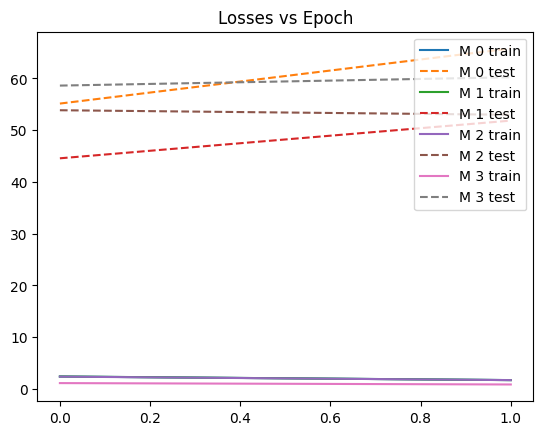

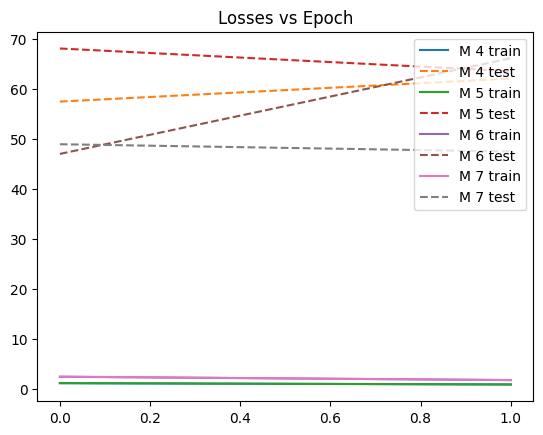

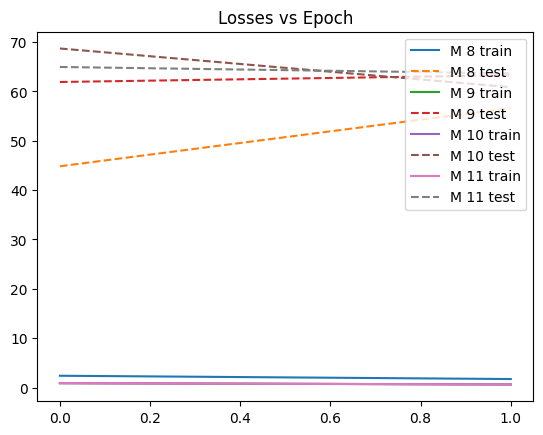

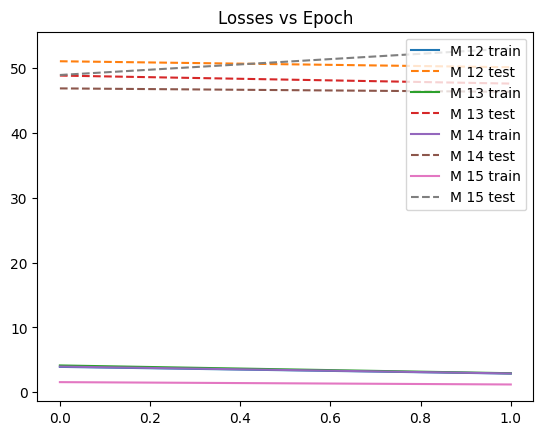

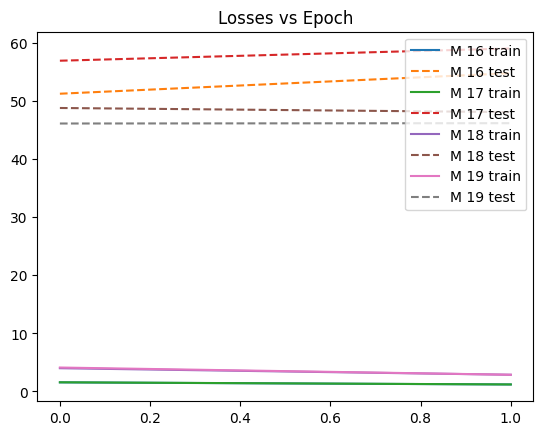

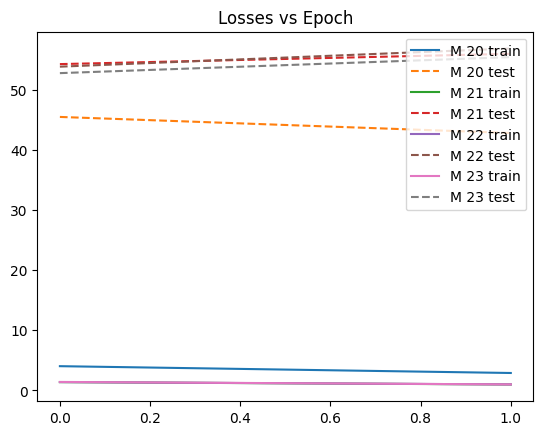

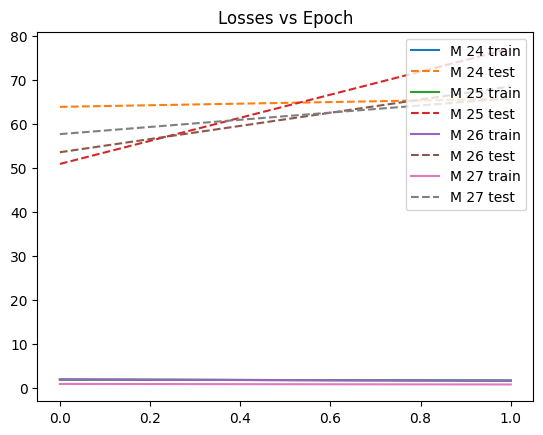

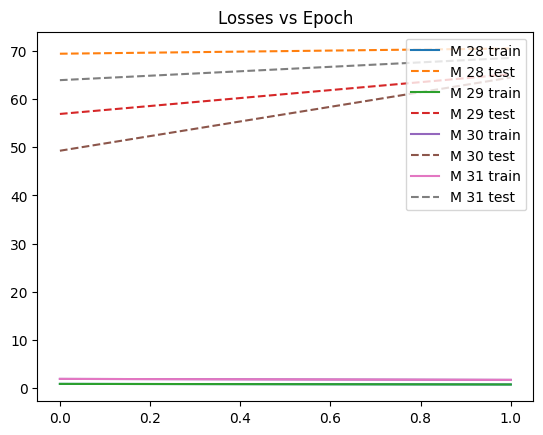

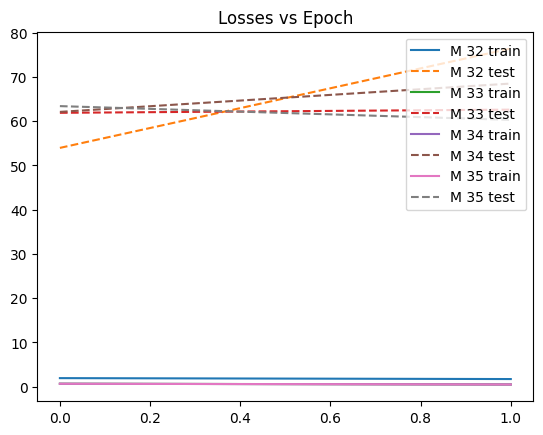

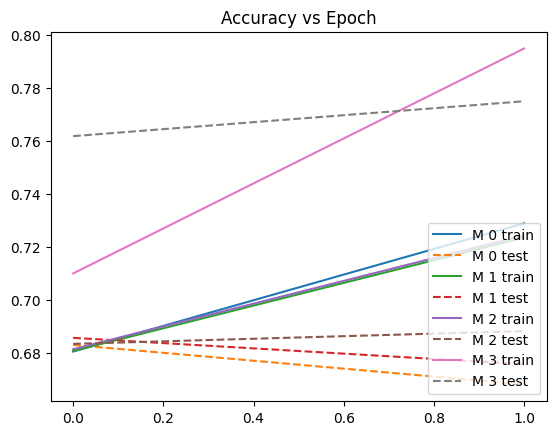

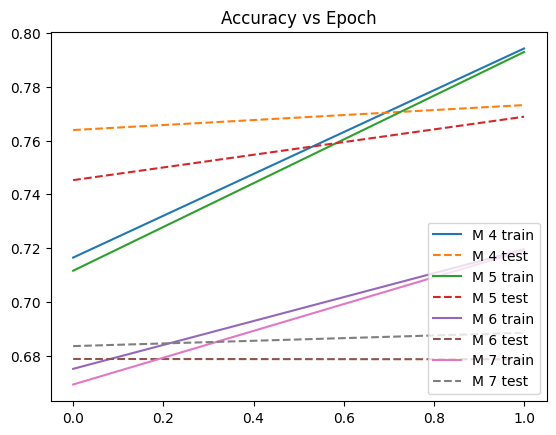

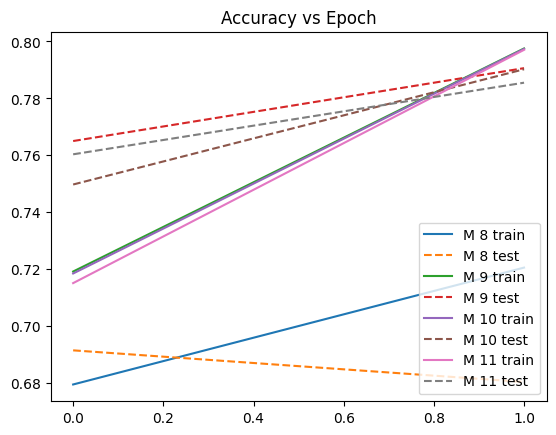

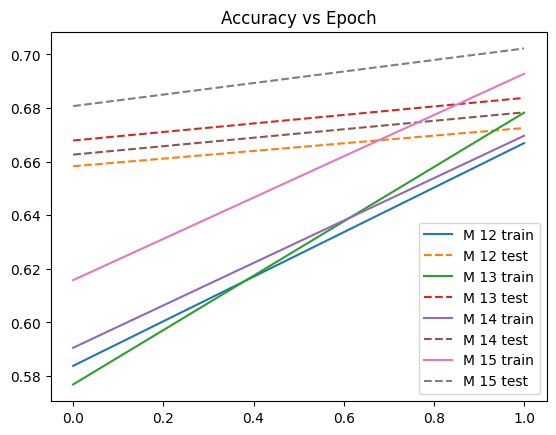

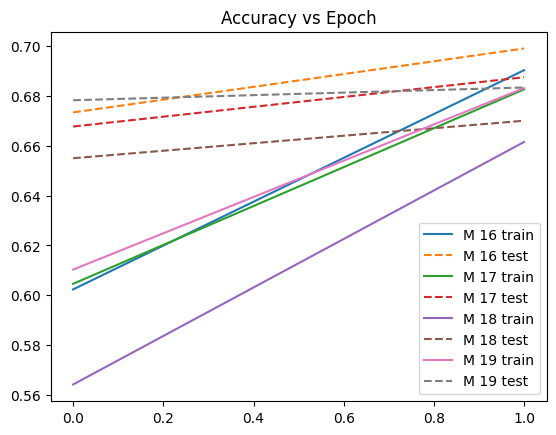

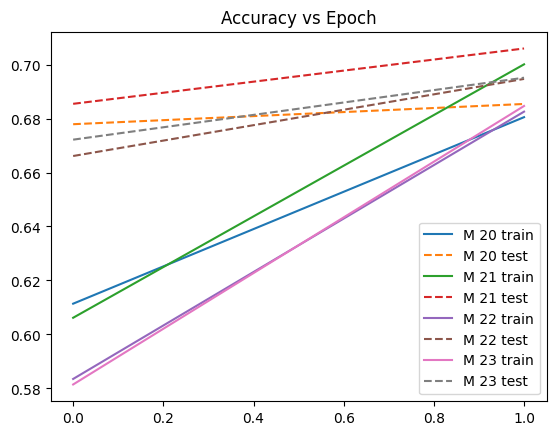

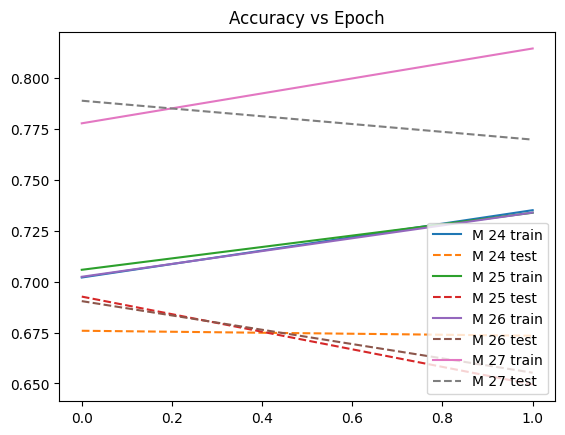

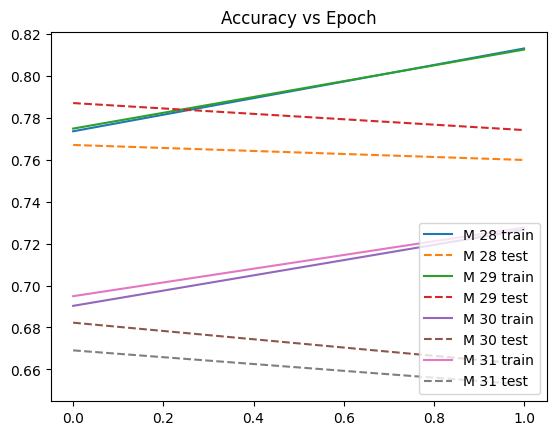

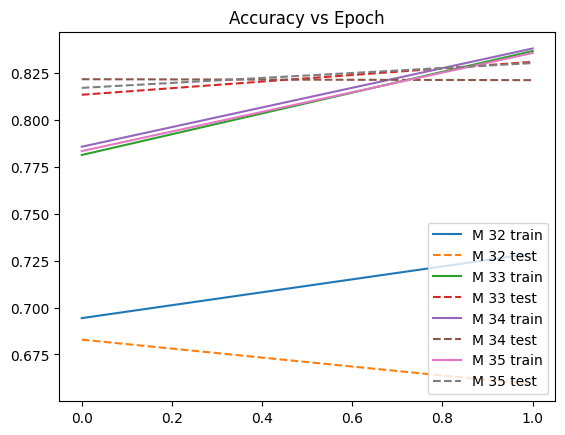

36


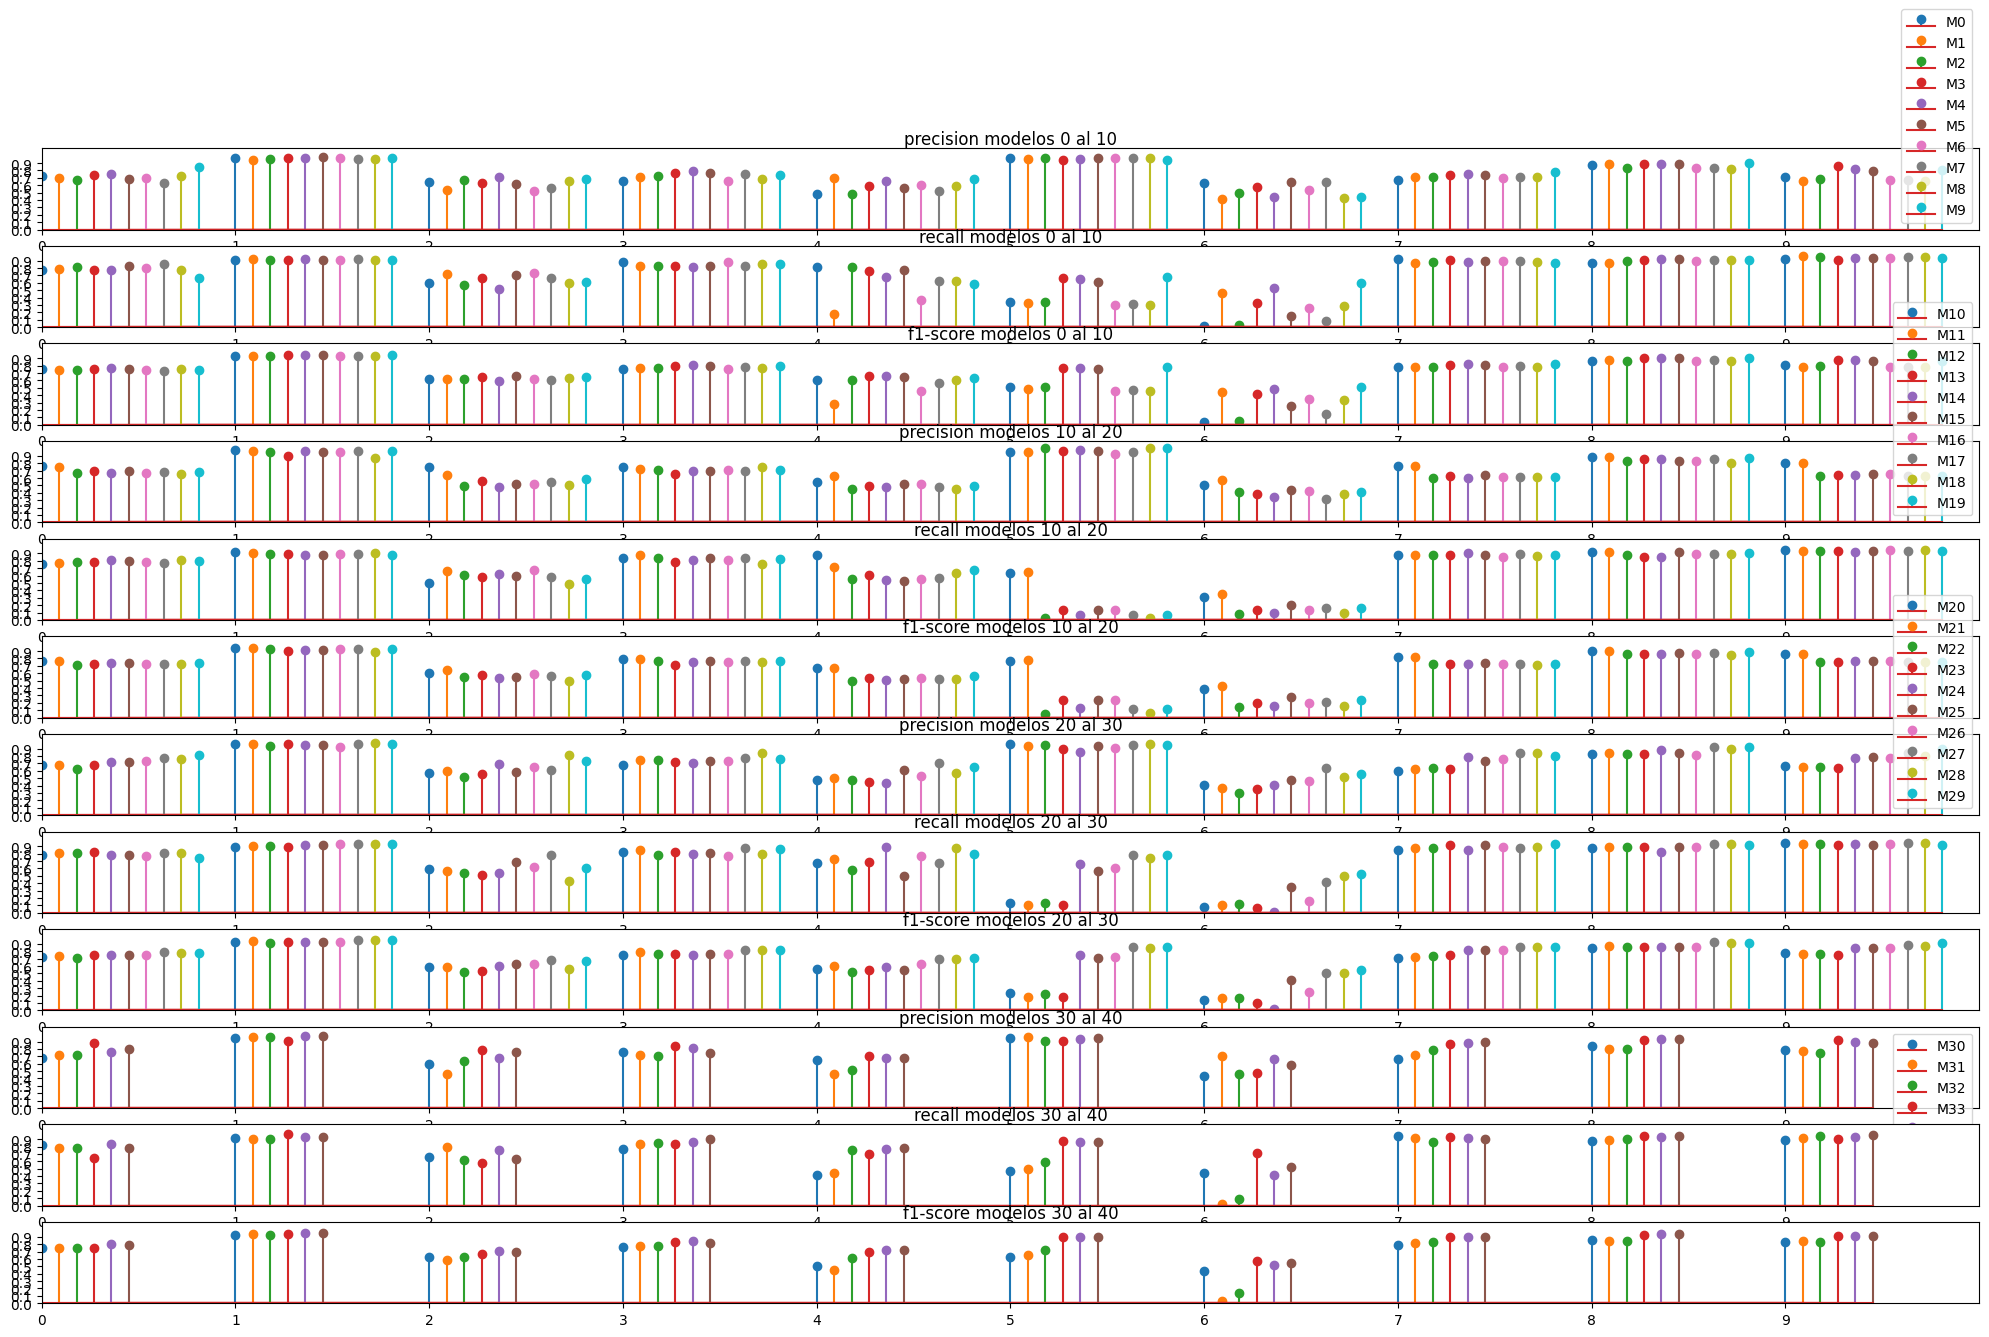

El modelo con mejor accuracy de train es el: M 34  ( Modelo con optimizacion Adam, Regularizacion kernel OrthogonalRegularizer y kerninit glorot_uniform ) ----> Acc: 0.8380476236343384
El modelo con mejor accuracy de validacion es el: M 33  ( Modelo con optimizacion Adam, Regularizacion kernel OrthogonalRegularizer y kerninit normal ) ----> ValAcc: 0.8309444189071655
El modelo con mejor loss de train es el: M 34 ( Modelo con optimizacion Adam, Regularizacion kernel OrthogonalRegularizer y kerninit glorot_uniform ) ----> Loss: 0.6420105695724487
El modelo con mejor loss de validacion es el: M 20 ( Modelo con optimizacion Adagrad, Regularizacion kernel l1_l2 y kerninit glorot_normal ) ----> ValLoss: 45.460201263427734


In [ ]:
#optimizadores_list = ['SGD']
#kernregs_list= ['l1','l2']
#kerninits_list=['normal','glorot_normal']
optimizadores_list = ['SGD',"Adagrad",'Adam']#,'RMSprop','nadam']
kernregs_list= ['l1','l2','l1_l2','OrthogonalRegularizer' ]
kerninits_list=['normal','glorot_uniform','glorot_normal']
results_vector=list()
for optimizadores in optimizadores_list:
  for kernregs in kernregs_list:
      for kerninits in kerninits_list:
        model_results_tuple = new_model_softmax(optimizadores,kernregs,kerninits)
        results_vector.append(model_results_tuple)
        #EDA_fromhist(model_results_tuple[0],model_results_tuple[2])
        #other_metrics(model_results_tuple[1],model_results_tuple[2])
plot_compare(results_vector)
plot_class_reports(results_vector)
print_best_models(results_vector)



Algunas metricas significativas de nuestro modelo:

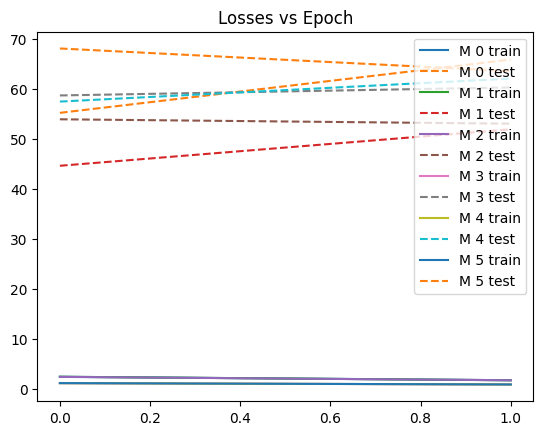

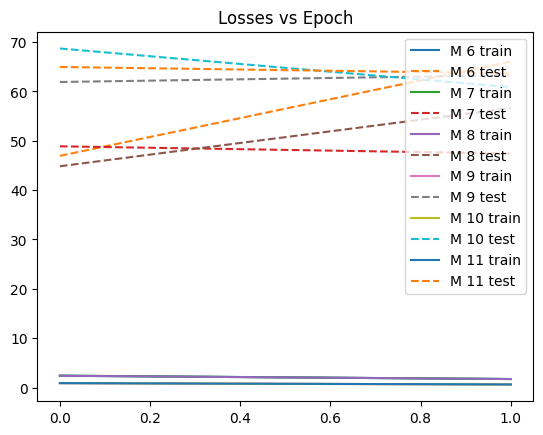

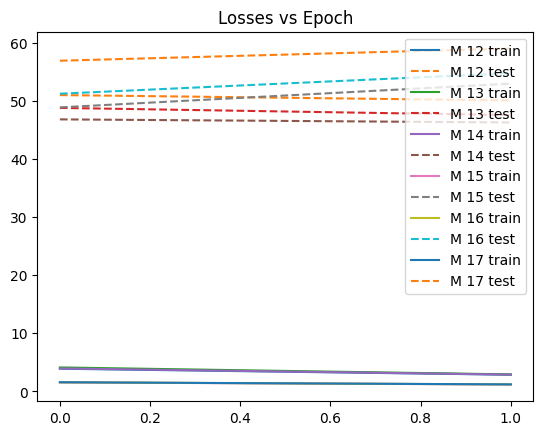

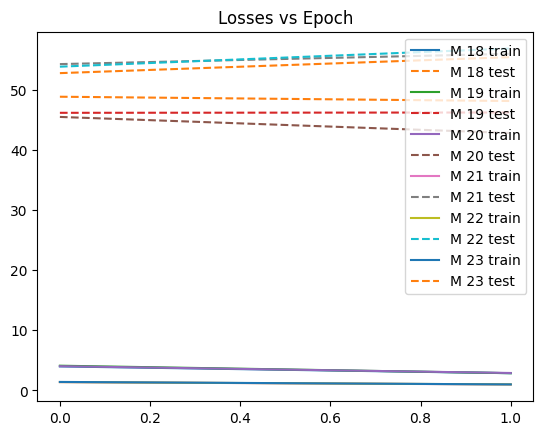

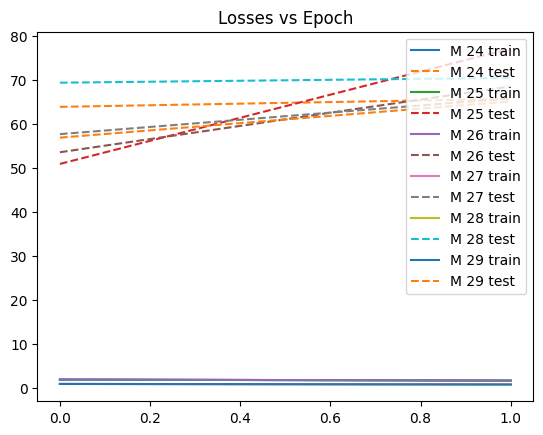

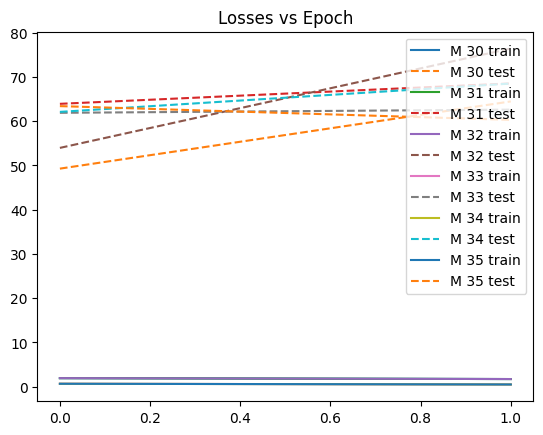

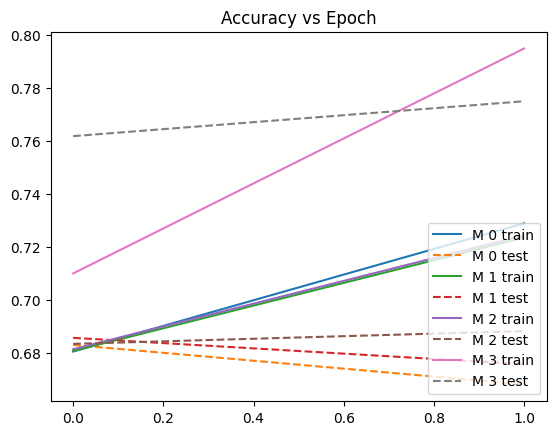

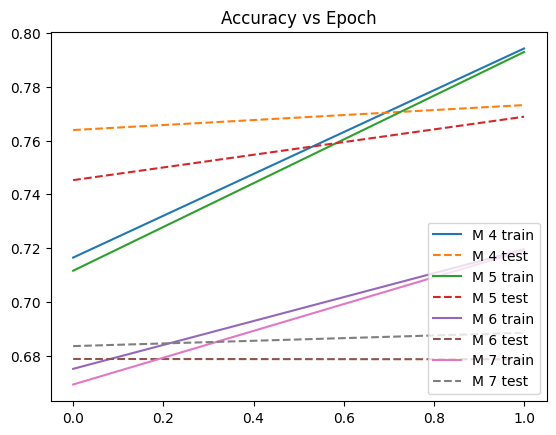

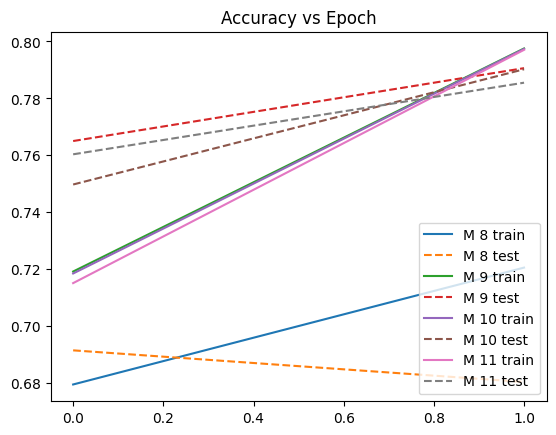

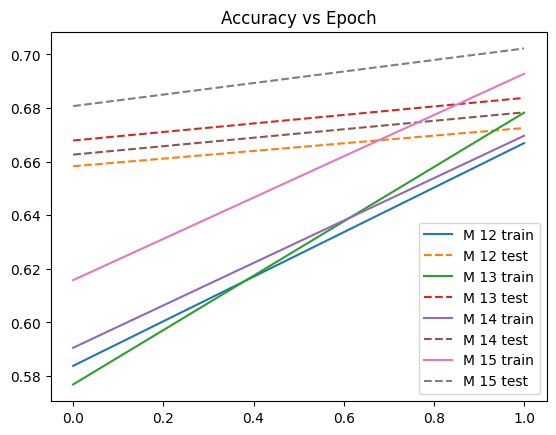

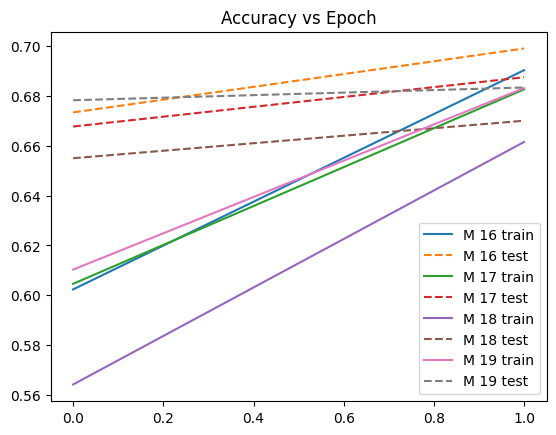

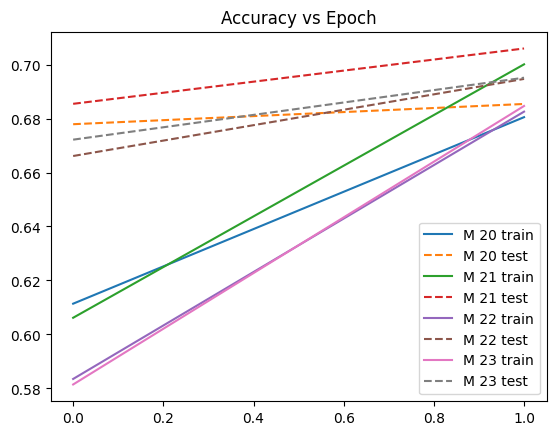

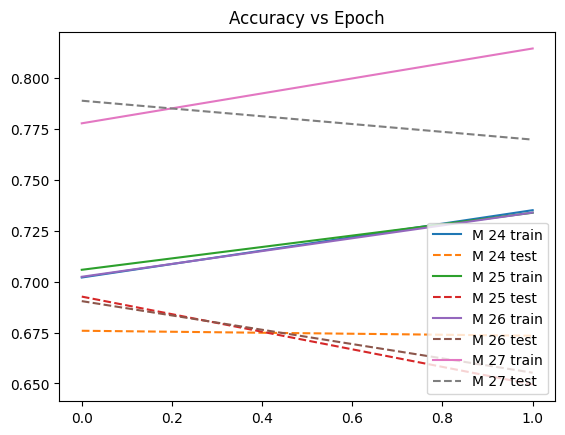

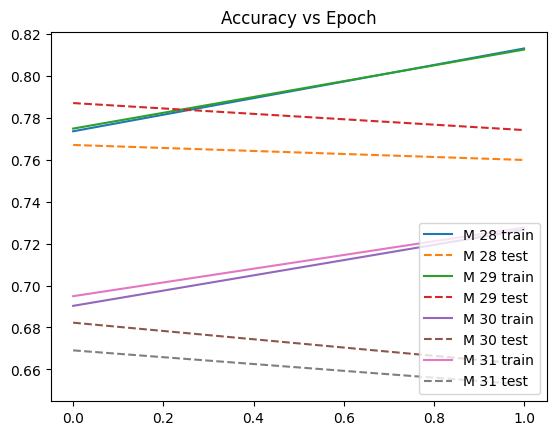

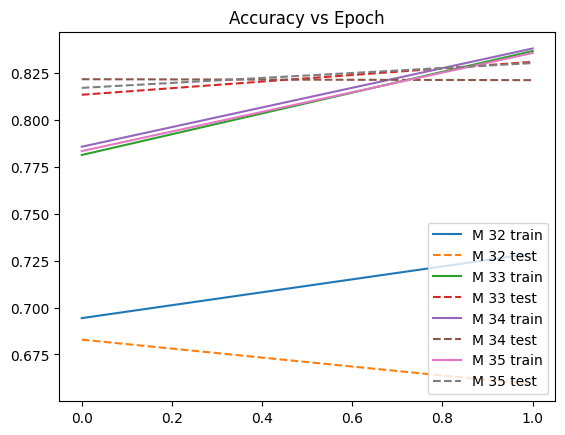

36


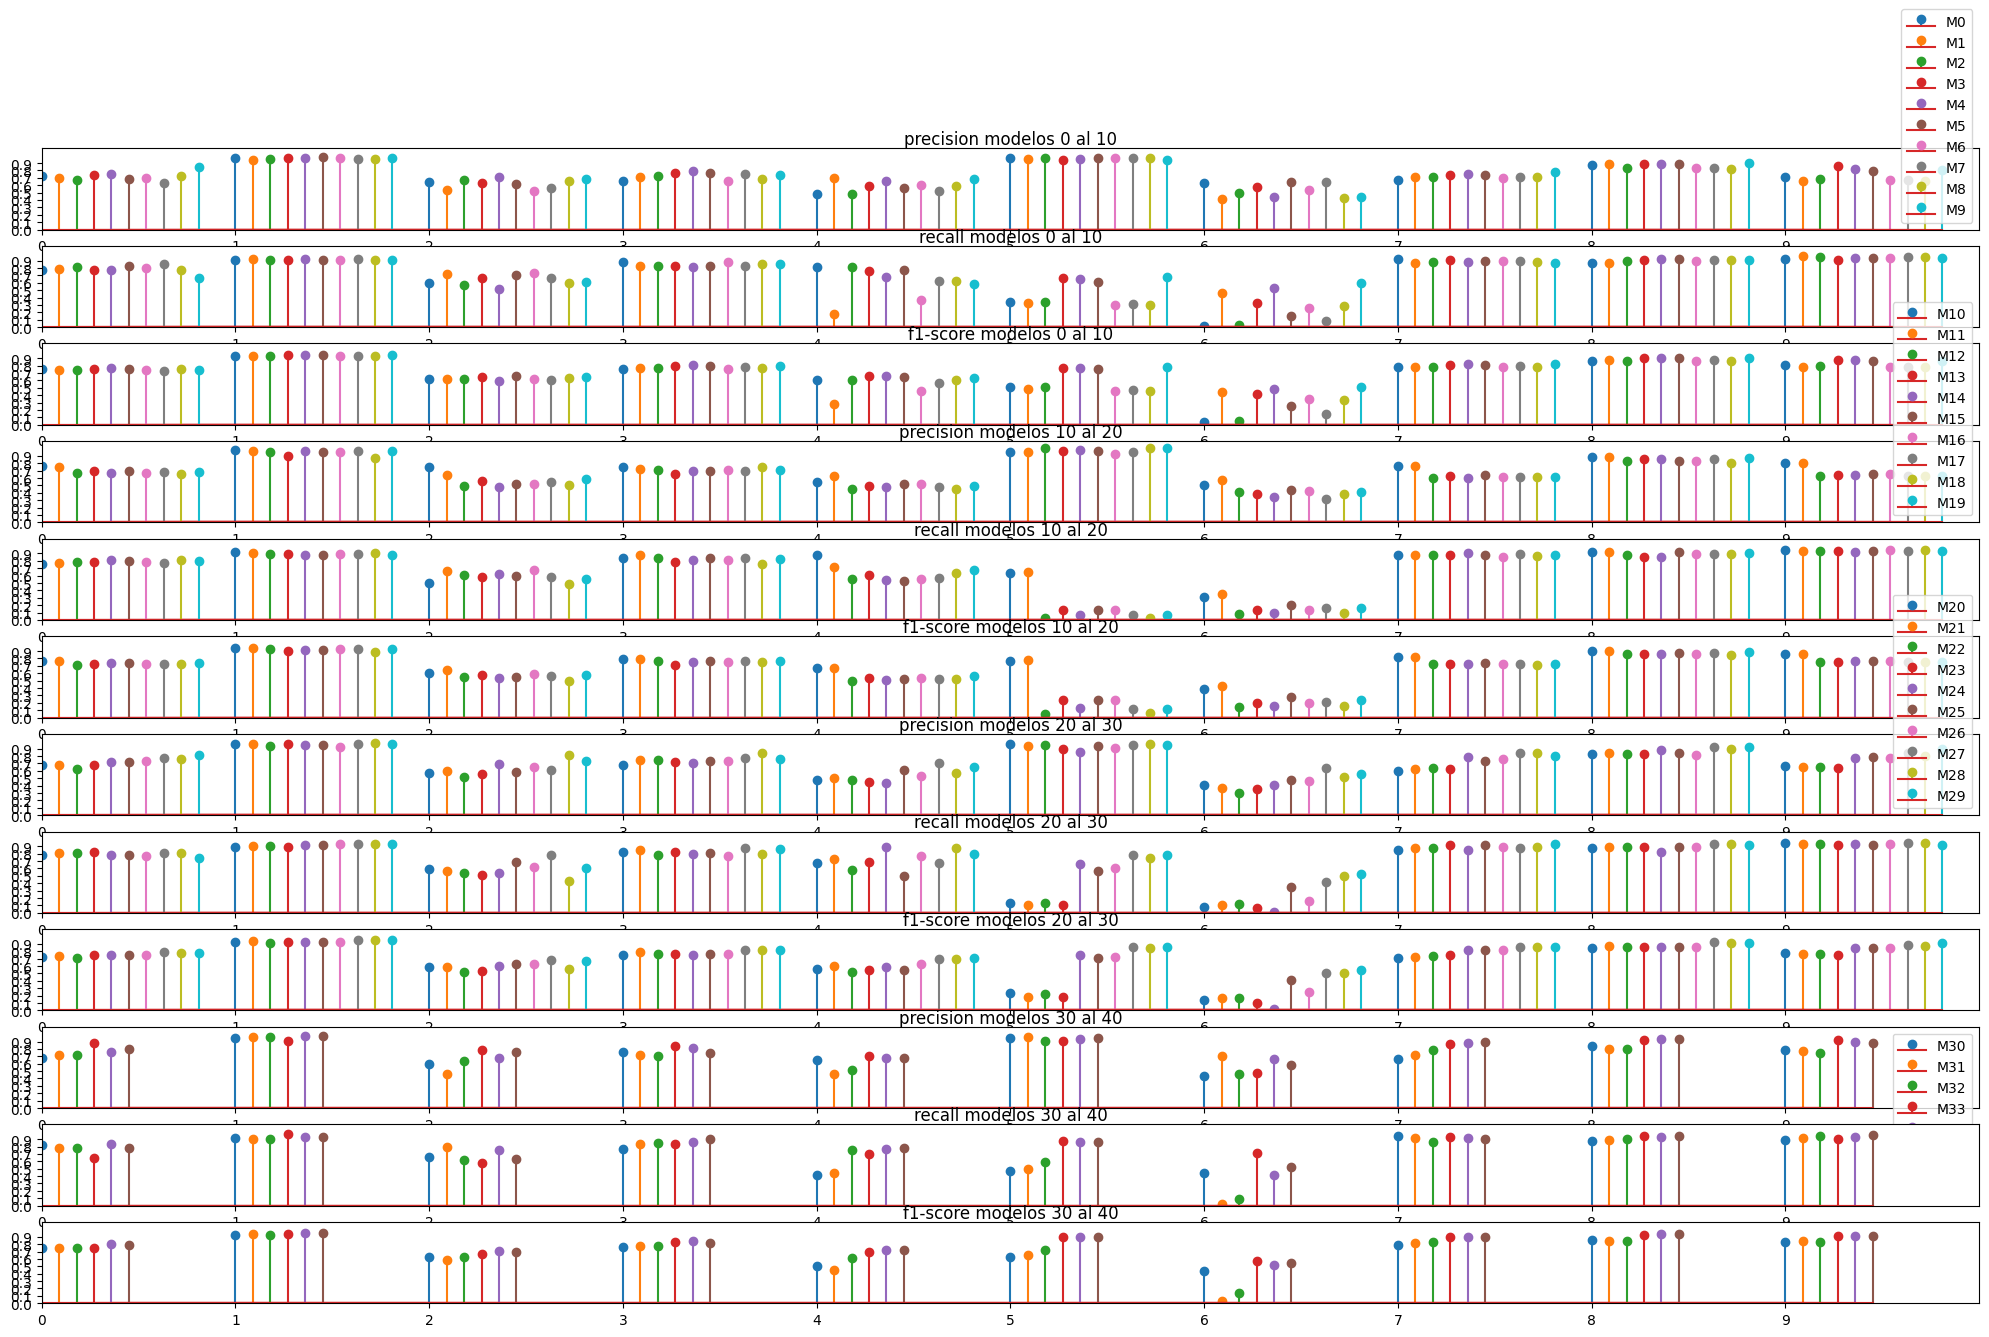

In [ ]:

  #plot_class_reports(results_vector)}

  plot_compare(results_vector,6)
  plot_class_reports(results_vector)

El modelo con mejor accuracy de train es el: M 34  ( Modelo con optimizacion Adam, Regularizacion kernel OrthogonalRegularizer y kerninit glorot_uniform ) ----> Acc: 0.8380476236343384
El modelo con mejor accuracy de validacion es el: M 33  ( Modelo con optimizacion Adam, Regularizacion kernel OrthogonalRegularizer y kerninit normal ) ----> ValAcc: 0.8309444189071655
El modelo con mejor loss de train es el: M 34 ( Modelo con optimizacion Adam, Regularizacion kernel OrthogonalRegularizer y kerninit glorot_uniform ) ----> Loss: 0.6420105695724487
El modelo con mejor loss de validacion es el: M 20 ( Modelo con optimizacion Adagrad, Regularizacion kernel l1_l2 y kerninit glorot_normal ) ----> ValLoss: 45.460201263427734


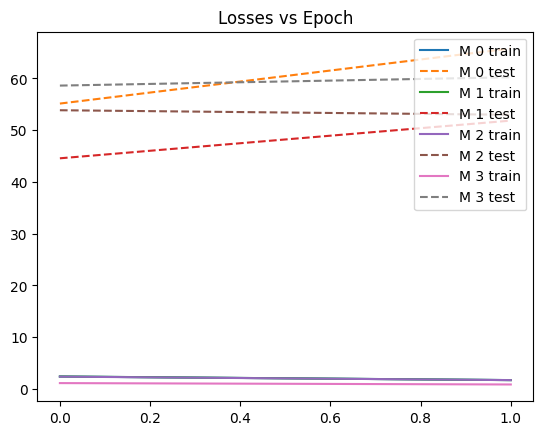

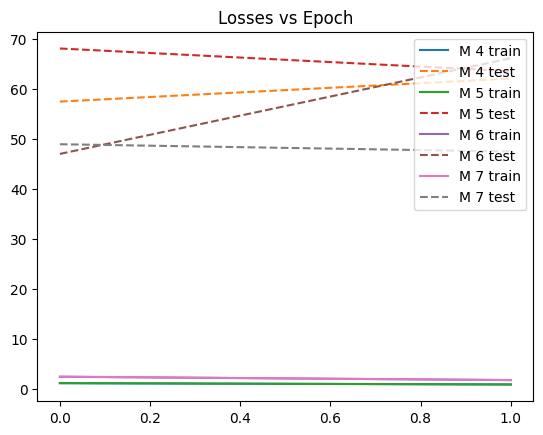

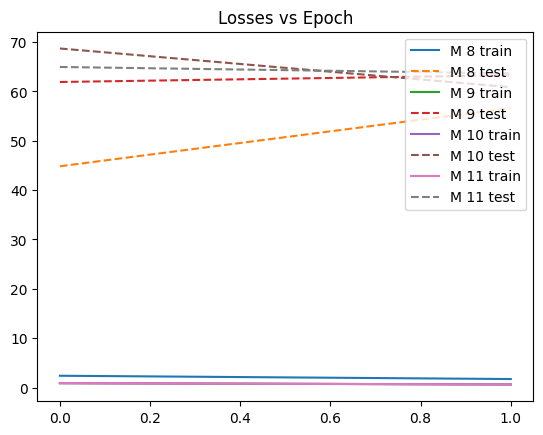

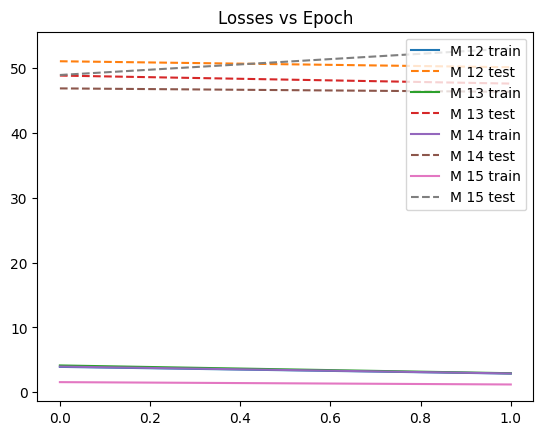

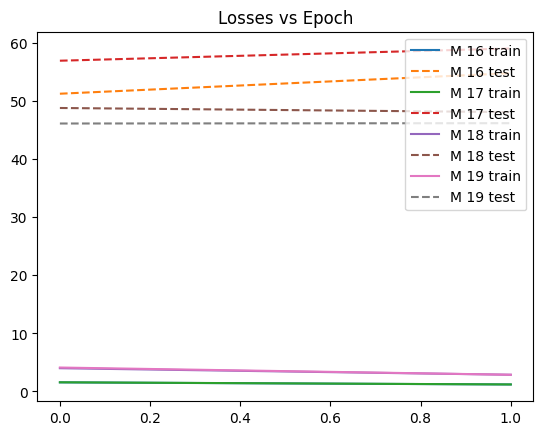

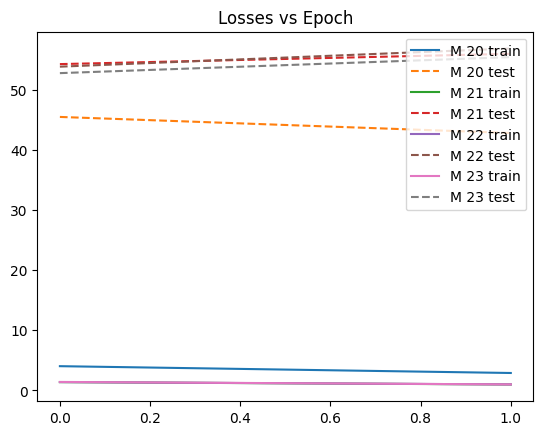

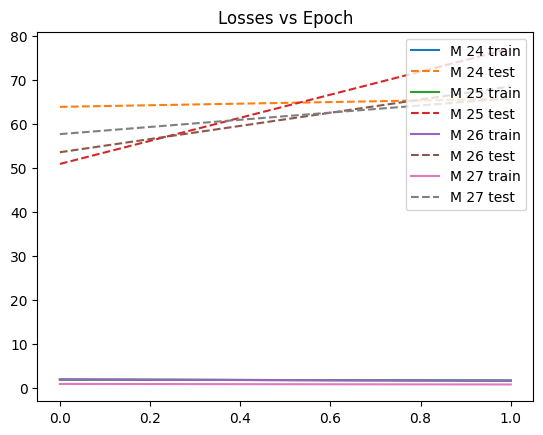

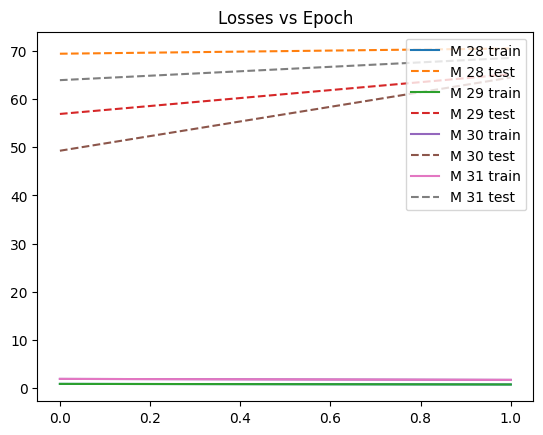

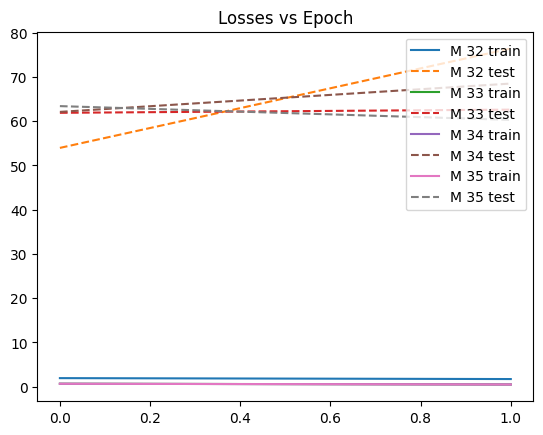

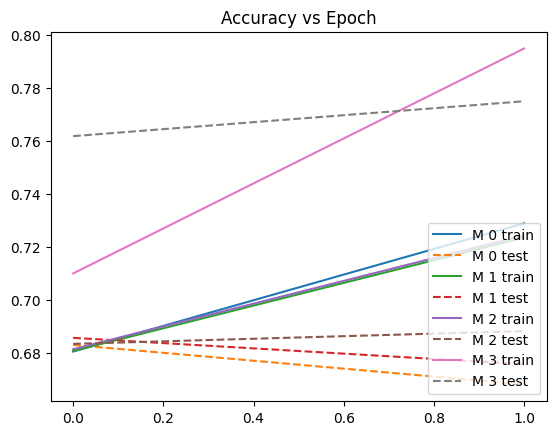

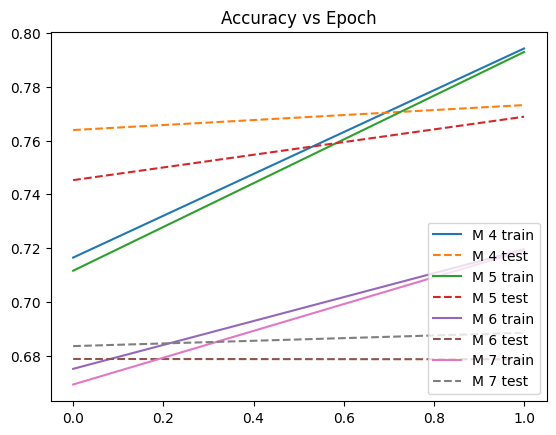

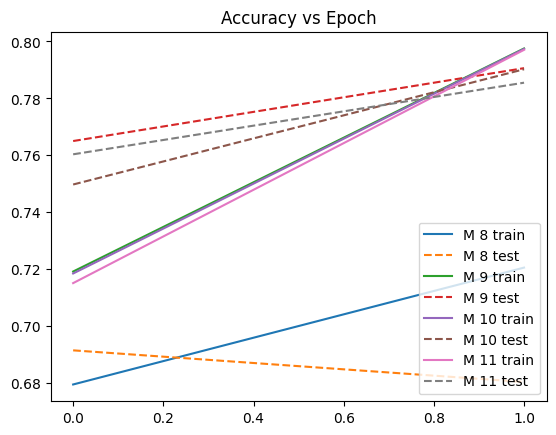

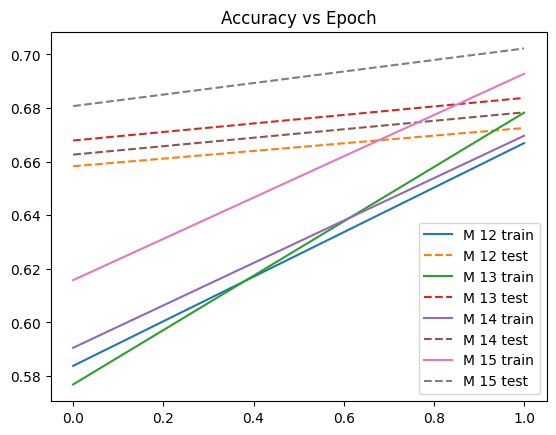

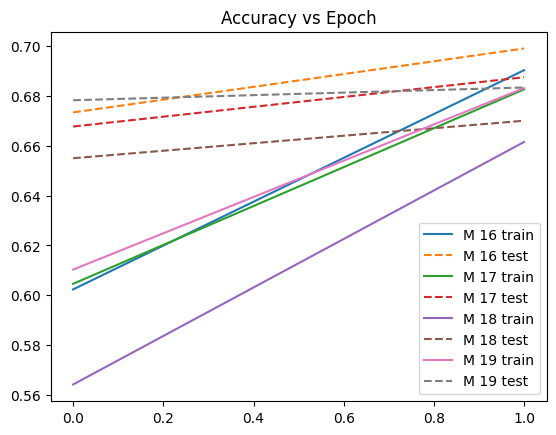

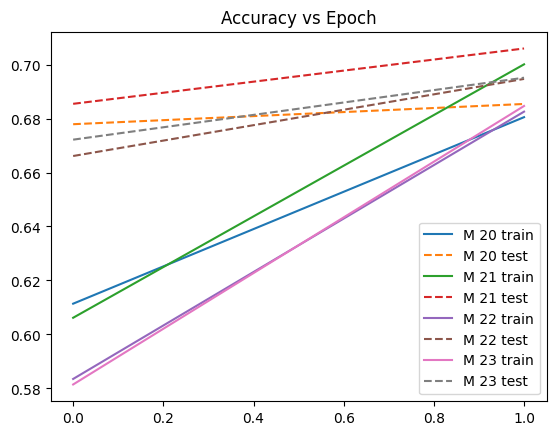

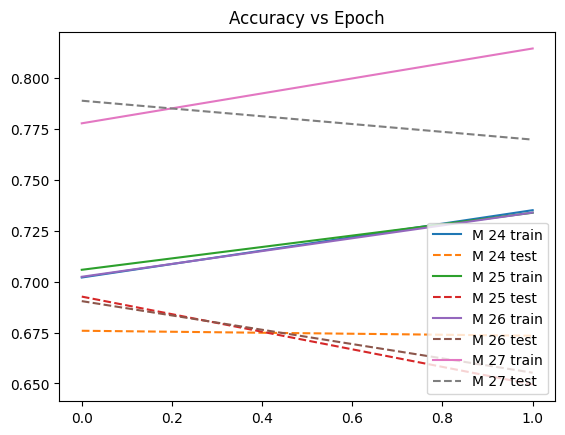

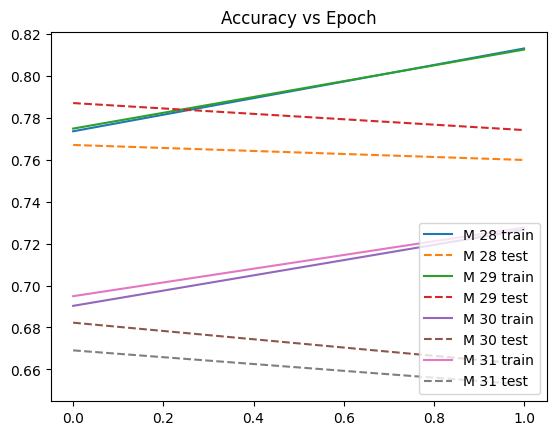

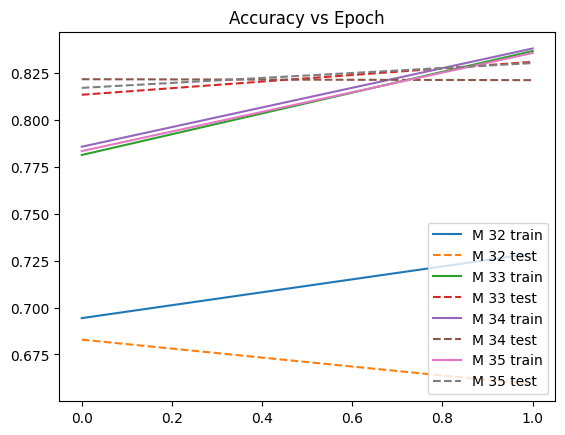

In [ ]:

print_best_models(results_vector)
plot_compare(results_vector, models_perfig=4)